## Intro to AI
### HW 3: Transfer Learning
#### Cindy Zhang, xinciz

In this exercise, I use PyTorch to train a pre-trained model and intend to identify historic landmarks. 

Note that I followed a tutorial here: 
https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

I also borrowed a lot of ideas and code from these sources:
https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
https://github.com/WillKoehrsen/pytorch_challenge/blob/master/Transfer%20Learning%20in%20PyTorch.ipynb

In [1]:
%matplotlib inline

In [2]:
#imports
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import shutil
from PIL import Image, ImageFilter
import pandas as pd

plt.ion()   # interactive mode
from torchvision import models

In [3]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
data_dir = "./"

# Number of classes in the dataset
num_classes = 10

# Number of epochs to train for
num_epochs = 15

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = False

Load Data
---------

Following the tutorial on Pytorch, I plan to use torchvision and torch.utils for loading data. 

We have about 27,000 images listed in the HW3_train.csv. A total of 33,710 images are present. 

However, note that not all images mentioned in the HW3_train.csv and HW3_test.csv are available in the Images folder. 

In [4]:
loc_id_train = []
image_id_train = []

loc_id_test = []
image_id_test = []

# read data from train.csv and test.csv
# split data to ignore the second column 
# store image_id and location_id in two lists
with open("./HW3_train.csv",'r') as f:
    for line in f:
        values = line.split(",")
        # the first part is word
        image_id_train.append(str(values[0])+".jpg")
        loc_id_train.append(int(values[2]))
        
with open("./HW3_test.csv",'r') as f:
     for line in f:
        values = line.split(",")
        # the first part is word
        image_id_test.append(str(values[0])+".jpg")
        loc_id_test.append(int(values[2]))

In [ ]:
# create a folder structure to store the train and test data seperately
# inside the train and test folders, create 10 folders each to store the location_ids
for labels in range(0,10):
    os.makedirs('train/'+str(labels))
    os.makedirs('test/'+str(labels))

In [ ]:
# move the images from images folder to their respective train/location_id folder
from pathlib import Path
for i in range(0,len(image_id_train)):
    old_path = "images/"+ image_id_train[i]
    new_path = "train/" + str(loc_id_train[i])+"/"+image_id_train[i]
    
    my_file = Path(old_path)
    if my_file.exists(): # check if the file exists
        os.rename(old_path, new_path)

In [ ]:
# move the images from images folder to their respective train/location_id folder
for i in range(0,len(image_id_test)):
    old_path = "images/"+ image_id_test[i]
    new_path = "test/" + str(loc_id_test[i])+"/"+image_id_test[i]
    
    my_file = Path(old_path)
    if my_file.exists(): # check if the file exists
        os.rename(old_path, new_path)

##### Data Structure
At this time, the data structure becomes the following:
````
/home directory
    /train
            /0
            /1
            .
            .
            /9
    /test
            /0
            /1
            .
            .
            /9
````

Next, we are going to transform the data and setup dataloaders. Dataloaders can help efficiently load data into memory in batches. Since the images are in folder structure, we read these to the DataLoader. Later when training, we will load the images from disk, apply transformations and yield a batch. The DataLoader will iterate through all batches in the respective DataLoader.


In [5]:
# code from Pytorch tutorial
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train','test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train','test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train','test']}

class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
print(device)

cuda:0


In [7]:
#check the number of classes 
image_datasets['train'].classes

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

Visualize a few images
----------------------
Let's visualize a few training images so as to understand the data
augmentations.



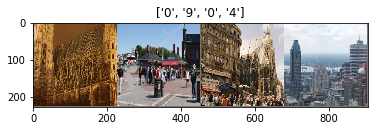

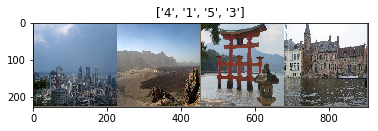

In [11]:
#code from pytorch tutorial
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


# Get a batch of test data
inputs, classes = next(iter(dataloaders['test']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [12]:
#code from PyTorch.org
#modified to remove references to 'val' data since validation is not required

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualizing the model predictions
---------------------------------------

Generic function to display predictions for a few images




In [13]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']): #changed from val to test
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




#### Initialize the Model

Load pre-trained model based on selected-model names

In [14]:
model_ft = models.resnet18(pretrained=True) ##load trained model
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, num_classes) #add a linear layer

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [15]:
# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
for name,param in model_ft.named_parameters():
    if param.requires_grad == True:
        print("\t",name)

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv1.weight
	 layer3.1.bn1.weight
	 layer3.1.bn1.bias
	 layer3.1.conv2.weight
	 layer3.1.b

Train and evaluate
------------------



In [16]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=15)

Epoch 0/14
----------
train Loss: 0.7890 Acc: 0.7576

Epoch 1/14
----------
train Loss: 0.5023 Acc: 0.8477

Epoch 2/14
----------
train Loss: 0.4147 Acc: 0.8743

Epoch 3/14
----------
train Loss: 0.3625 Acc: 0.8920

Epoch 4/14
----------
train Loss: 0.3188 Acc: 0.9043

Epoch 5/14
----------
train Loss: 0.3002 Acc: 0.9108

Epoch 6/14
----------
train Loss: 0.2788 Acc: 0.9166

Epoch 7/14
----------
train Loss: 0.1996 Acc: 0.9399

Epoch 8/14
----------
train Loss: 0.1783 Acc: 0.9474

Epoch 9/14
----------
train Loss: 0.1691 Acc: 0.9487

Epoch 10/14
----------
train Loss: 0.1618 Acc: 0.9510

Epoch 11/14
----------
train Loss: 0.1600 Acc: 0.9528

Epoch 12/14
----------
train Loss: 0.1556 Acc: 0.9530

Epoch 13/14
----------
train Loss: 0.1591 Acc: 0.9531

Epoch 14/14
----------
train Loss: 0.1504 Acc: 0.9549

Training complete in 87m 35s
Best val Acc: 0.954876


In [17]:
PATH = "/home/ubuntu/Model_FT.pt"
torch.save(model_ft, PATH)

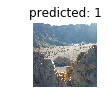

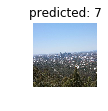

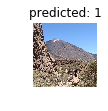

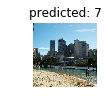

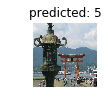

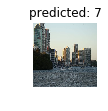

In [18]:
visualize_model(model_ft)

In [8]:
PATH = "/home/ubuntu/Model_FT.pt"
model2 = torch.load(PATH)

In [10]:
#code from PyTorch.org
#modified to remove references to 'val' data since validation is not required

def predict(model,criterion):
    since = time.time()
    predicted_labels = []
    real_labels = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0


    # Each epoch has a training and validation phase
    for phase in ['test']:
        model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels) 
            
            _, preds = torch.max(outputs, 1)
            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            predicted_labels.append(preds)
            real_labels.append(labels.data)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print('{} Loss: {:.4f} Accuracy: {:.4f}'.format(
            phase, epoch_loss, epoch_acc))

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    return predicted_labels,real_labels

In [11]:
criterion = nn.CrossEntropyLoss()

predicted_labels, real_labels = predict(model2,criterion)

test Loss: 0.0469 Accuracy: 0.9870

Training complete in 0m 15s


In [12]:
print(type(real_labels[0]))
#print(predicted_labels)
    

<class 'torch.Tensor'>


In [13]:
confusion_matrix = torch.zeros(num_classes, num_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['test']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model2(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

tensor([[337.,   0.,   0.,   1.,   1.,   0.,   0.,   0.,   0.,   2.],
        [  1., 389.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,   0.],
        [  0.,   0., 353.,   3.,   1.,   0.,   2.,   0.,   2.,   0.],
        [  1.,   0.,   2., 333.,   0.,   0.,   2.,   0.,   0.,   0.],
        [  0.,   1.,   1.,   0., 334.,   0.,   2.,   4.,   2.,   1.],
        [  0.,   0.,   0.,   0.,   1., 334.,   0.,   1.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0., 309.,   0.,   0.,   0.],
        [  0.,   0.,   1.,   0.,   2.,   0.,   0., 313.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   1.,   2., 328.,   1.],
        [  1.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,   0., 242.]])


In [14]:
confusion_matrix_normalized = torch.zeros(num_classes, num_classes)

for i in range(num_classes): 
    sum = confusion_matrix[i].sum()
    for j in range(num_classes):
        confusion_matrix_normalized[i,j] = confusion_matrix[i,j] / sum

print(confusion_matrix_normalized)

tensor([[0.9883, 0.0000, 0.0000, 0.0029, 0.0029, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0059],
        [0.0026, 0.9923, 0.0000, 0.0000, 0.0000, 0.0051, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.9778, 0.0083, 0.0028, 0.0000, 0.0055, 0.0000, 0.0055,
         0.0000],
        [0.0030, 0.0000, 0.0059, 0.9852, 0.0000, 0.0000, 0.0059, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0029, 0.0029, 0.0000, 0.9681, 0.0000, 0.0058, 0.0116, 0.0058,
         0.0029],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0030, 0.9940, 0.0000, 0.0030, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0032, 0.0000, 0.0063, 0.0000, 0.0000, 0.9905, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0030, 0.0060, 0.9880,
         0.0030],
        [0.0041, 0.0041, 0.0000, 0.0000, 0.0000, 0.0041, 0.0000, 0.0000, 0.0000,
         0.9878]])


In [15]:
precision = {}

for cat in range(num_classes):
    sum = confusion_matrix[cat].sum()
    precision[cat] = confusion_matrix[cat, cat]/sum

recall = {}

for cat in range(num_classes):
    sum = confusion_matrix[:,cat].sum()
    recall[cat] = confusion_matrix[cat, cat]/sum

In [16]:
locations  = {}

locations[0] = "St. Stephan's Cathedral, Austria"
locations[1] = "Teide, Spain"
locations[2] = "Tallinn, Estonia"
locations[3] = "Brugge, Belgium"
locations[4] = "Montreal, Canada"
locations[5] = "Itsukushima Shrine, Japan"
locations[6] = "Shanghai, China"
locations[7] = "Brisbane, Australia"
locations[8] = "Edinburgh, Scotland"
locations[9] = "Stockholm, Sweden"

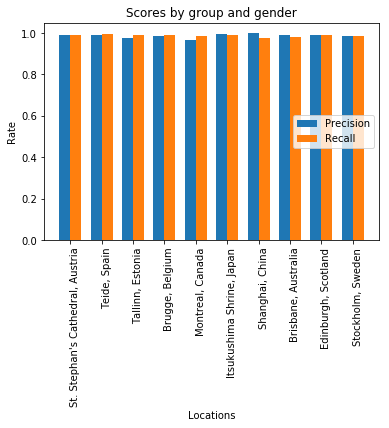

<Figure size 432x288 with 0 Axes>

In [17]:
n_groups = 10

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35

ax.bar(index, precision.values(), bar_width,
                label="Precision")

ax.bar(index + bar_width, recall.values(), bar_width,
                label="Recall")

ax.set_xlabel('Locations')
ax.set_ylabel('Rate')
ax.set_title('Scores by group and gender')
ax.set_xticks(index+ bar_width /2)
ax.set_xticklabels(locations.values(),ha="left",rotation = 90)
ax.legend(loc = "right")

plt.figure()
plt.show()